#  Le modèle des espèces non vues appliqué à la littérature chevaleresque ibérique

### Introduction

Ce code est largement repris du projet [Forgotten Books](https://github.com/mikekestemont/forgotten-books) de Mike Kestemont *et al*.

Le notebook repose sur le package `copia`, disponible sur [Github](https://github.com/mikekestemont/copia) et documenté [ici](https://copia.readthedocs.io/en/latest/). Une version récente peut être installée depuis PyPI (`>>> pip install copia`). Dans la cellule ci-dessous, nous importons également les autres modules dont le logiciel dépend.


In [36]:
                                                    #############
                                                    #IMPORTATIONS
                                                    ############
#Cette section est essentielle pour préparer l'environnement d'analyse. Elle inclut toutes les bibliothèques 
# nécessaires, configure les styles graphiques et importe des modules spécifiques à `copia`
#, un package utilisé pour des calculs avancés de richesse 
# et de diversité, ainsi que pour des visualisations spécialisées.


# Bibliothèques Standard
import os  # Pour interagir avec le système de fichiers
from pathlib import Path  # Pour manipuler les chemins de fichiers

# Bibliothèques Tierces (pandas, matplotlib, numpy)
import pandas as pd  # Pour la manipulation de données tabulaires
import matplotlib.pyplot as plt  # Pour la visualisation de données
import numpy as np  # Pour les calculs sur des tableaux de données
np.random.seed(543251)  # Fixer la graine aléatoire pour la reproductibilité

# Bibliothèques Spécifiques au package'Copia'
import copia.utils as u  # Fonctions utilitaires de Copia
from copia.richness import *  # Pour les calculs de richesse
from copia.hill import hill_numbers  # Pour calculer les nombres de Hill
from copia.utils import survival_ratio, evenness  # Pour calculer les ratios de survie et l'équitabilité
from copia.plot import (
    accumulation_curve,  # Pour tracer les courbes d'accumulation
    multi_kde,  # Pour tracer des courbes KDE multiples
    survival_errorbar,  # Pour ajouter des barres d'erreur de survie
    evenness_plot,  # Pour tracer les profils d'équitabilité
    density,  # Pour tracer des graphiques de densité
    hill_plot  # Pour tracer les profils des nombres de Hill
)

# Configuration de Matplotlib
plt.style.use('science')  # Style scientifique pour les graphiques
plt.rcParams['axes.spines.right'] = False  # Supprimer la bordure droite des graphiques
plt.rcParams['axes.spines.top'] = False  # Supprimer la bordure supérieure des graphiques
plt.rcParams['xtick.top'] = False  # Supprimer les graduations en haut des graphiques
plt.rcParams['ytick.right'] = False  # Supprimer les graduations à droite des graphiques


In [3]:
#####################
# Lecture et Pré-traitement Fichier CSV
#####################

# Crée un objet Path représentant le chemin du fichier CSV.
file_path = Path('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/adata_geocoded.csv')

# Lecture du fichier CSV avec pandas, en utilisant le chemin pathlib et l'encodage 'latin-1'
 df = pd.read_csv(file_path, encoding='latin-1')


# Convertit toutes les colonnes de type chaîne de caractères en minuscules et supprime les espaces
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.lower().str.strip()


    df.head()


In [5]:
# Initialisation d'un dictionnaire vide pour stocker les résultats de chaque langue
lits = {}

# Pour chaque langue de la liste spécifiée, filtrer les données et extraire les informations nécessaires
for lang in ['portugais', 'castillan', 'catalan']:
    # Utiliser la méthode query() pour sélectionner les lignes du DataFrame où 'language' correspond à la langue en cours d'itération
    df_lang = df.query(f'language == "{lang}"')
    
    # Stocker dans le dictionnaire 'lits' une nouvelle entrée où la clé est la langue,
    # et la valeur est un DataFrame contenant uniquement les colonnes 'title', 'signature', et 'repository'
    lits[lang] = df_lang[['title', 'signature', 'repository']]


## Data

Nous repremons le jeu de données utilisé dans l'étude, disponible sous forme de fichier `cvs` dans le répertoire `data/master`. Nous le chargeons et les convertissons en `DataFrames` avec `pandas` :


Ensuite, nous extrayons plusieurs statistiques globales de ces jeux de données ($f_1$, $f_2$, $n$, et $S$, ainsi que le nombre de dépôts distincts), que nous interprétons comme des "données d'abondance" en écologie :


In [7]:

# Initialisation d'une liste pour stocker les résultats
stats = []

# Boucle sur chaque ensemble de données de langue stocké dans le dictionnaire 'lits'
for lit, df in lits.items():
    # Calculer l'abondance de chaque titre unique dans l'ensemble de données
    abundance = u.to_abundance(df['title'])
    
    # Obtenir des mesures statistiques de base à partir des données d'abondance
    s = u.basic_stats(abundance)
    
    # Initialiser un dictionnaire pour contenir les données pour la langue actuelle
    d = {'langue': lit}
    
    # Extraire des valeurs statistiques spécifiques des résultats et les ajouter au dictionnaire
    for k in ('f1', 'f2', 'S', 'n'):
        d[k] = s[k]
    
    # Compter les dépôts uniques dans l'ensemble de données et les ajouter au dictionnaire
    d['repo'] = len(set(df['repository']))
    
    # Ajouter le dictionnaire avec les statistiques de la langue actuelle à la liste
    stats.append(d)

# Afficher la liste contenant les données statistiques pour chaque langue
stats


[{'language': 'portugais', 'f1': 3, 'f2': 1, 'S': 4, 'n': 5, 'repo': 5},
 {'language': 'castillan', 'f1': 16, 'f2': 3, 'S': 21, 'n': 33, 'repo': 15},
 {'language': 'catalan', 'f1': 4, 'f2': 1, 'S': 5, 'n': 6, 'repo': 6}]

Nous transformons ces resultats dans un dataframe :


In [10]:
stats_df = pd.DataFrame(stats)
stats_df['language'] = stats_df['language'].str.lower()
stats_df.loc[len(stats_df)] = ['all'] + list(stats_df[['f1', 'f2', 'S', 'n']].sum()) + [None]
stats_df = stats_df.set_index('language')
stats_df

,f1,f2,S,n,repo
language,,,,,
portugais,3,1,4,5,5
castillan,16,3,21,33,15
catalan,4,1,5,6,6
all,23,5,30,44,None


Nous ajoutons explicitement une étiquette de langue à chaque titre d'œuvre, afin d'éviter les conflits de designation :


In [11]:
# Initialisation d'une liste pour stocker les DataFrames
dfs = []

# Boucle sur chaque ensemble de données de langue stocké dans le dictionnaire 'lits'
for lang, df in lits.items():
    # Ajouter un tag de langue à chaque titre pour éviter les conflits de nommage
    df['title'] = [t + '_' + lang for t in df['title']]
    
    # Ajouter le DataFrame modifié à la liste 'dfs'
    dfs.append(df)
    
# Concaténer tous les DataFrames en un seul, en ignorant l'index d'origine
df_all = pd.concat(dfs, ignore_index=True)

# Afficher le DataFrame combiné
df_all

/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,title,signature,repository
0,estoire del saint graal_portugais,not/cns-ts01/001/0012,arquivo distrital do porto
1,estoire del saint graal_portugais,ms. 643 an/tt,arquivo nacional torre do tombo
2,queste-mort artu_portugais,cod. 2594 han mag,osterreichische nationalbibliothek
3,merlin (suite de merlin)_portugais,ms. 2434,biblioteca de catalunya
4,tristan en prose_portugais,"cã³dices, l. 1501/7",archivo histã³rico nacional
5,estoire del saint graal_castillan,ms 1877,biblioteca general histã³rica de la universida...
6,lancelot_castillan,ms. 9611,biblioteca nacional de espaã±a
7,merlin (suite de merlin)_castillan,ms. 1877,biblioteca universitaria de salamanca
8,queste-mort artu_castillan,ms. 1877,biblioteca universitaria de salamanca
9,estoire del saint graal_castillan,ms. 9-10-2/2100,real academia de la historia


Nous convertissons ces informations en données d'abondance, en utilisant une fonction utilitaire de `copia` :


In [14]:
abundance = u.to_abundance(df_all['title'])

Nous stockerons tous les résultats dans le dossier `outputs` :

In [15]:
# Essayer de créer le répertoire 'outputs'
try:
    os.mkdir('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs')
# Si le répertoire existe déjà, ignorer l'erreur
except FileExistsError:
    pass


Tout d'abord, nous obtenons des estimations ponctuelles pour la survie du nombre d'œuvres ("Chao1") et de documents ("minsample") :


In [16]:
# Affichage des estimations originales du nombre d'œuvres et du nombre de documents
print('nombre original d\'œuvres :', diversity(abundance, method='chao1'))
print('nombre original de documents :', diversity(abundance, method='minsample'))

original # works: 81.69772727272726
original # documents: 713.3858693858695




Nous continuons en traçant des courbes de densité qui montrent les estimations bootstrap (et les quantiles associés) des estimations de diversité sous forme de ratios de survie. Notez que `survival_ratio()` convertit l'estimation initiale en un taux de survie, c'est-à-dire en prenant le ratio des estimations par rapport aux valeurs observées de $S$ et $n$, respectivement.


In [17]:
# Calcul du taux de survie des oeuvres pour l'ensemble des données d'abondance, utilisant la méthode 'chao1' avec 10 000 itérations
wsurvival_all = survival_ratio(abundance, method='chao1', n_iter=10000)


100%|██████████| 10000/10000 [00:00<00:00, 16188.70it/s]


In [18]:
wsurvival_all

{'survival': 0.3672072773805881,
 'bootstrap': array([0.44489051, 0.67855583, 0.44489051, ..., 0.24376632, 0.18917213,
        0.49895632]),
 'lci': 0.13587205245640785,
 'uci': 0.8301398186738969}

In [21]:
# Définition d'une fonction pour tracer la courbe de densité des taux de survie
def plot_survival():
    # Créer un graphique de densité pour les ratios de survie, avec des paramètres spécifiques
    ax = density(wsurvival_all, figsize=(5, 4), xlim=(0.5, 0.9))
    
    # Supprimer les étiquettes des graduations de l'axe Y
    ax.set_yticklabels([])
    
    # Supprimer les graduations sur l'axe Y
    ax.tick_params(axis='y', which='both', left=False)
    
    # Supprimer le label de l'axe Y
    ax.set_ylabel(None)
    
    # Rendre la bordure gauche du graphique invisible
    ax.spines['left'].set_visible(False)
    
    # Sauvegarder le graphique dans un fichier PDF
    plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/dens_works.pdf')

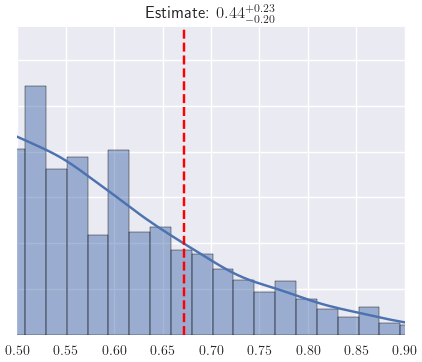

In [23]:
plot_survival()

Nous exécutons la même opération pour les documents en changeant le parametre ; method='minsample':


In [24]:
dsurvival_all = survival_ratio(abundance, method='minsample', n_iter=10000)

  0%|          | 16/10000 [00:00<02:37, 63.55it/s]

Tolerance criterion not met: 59.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 59.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
  0%|          | 41/10000 [00:00<02:23, 69.36it/s]

Tolerance criterion not met: 51.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 51.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|          | 105/10000 [00:01<02:18, 71.55it/s]

Tolerance criterion not met: 47.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 47.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 161/10000 [00:02<02:16, 71.97it/s]

Tolerance criterion not met: 53.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 53.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  4%|▍         | 377/10000 [00:05<02:14, 71.46it/s]

Tolerance criterion not met: 47.0 > 0.1


  6%|▌         | 552/10000 [00:07<02:13, 70.58it/s]

Tolerance criterion not met: 49.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 49.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 560/10000 [00:07<02:13, 70.84it/s]

Tolerance criterion not met: 49.0 > 0.1
Tolerance criterion not met: 45.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 45.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  6%|▌         | 576/10000 [00:08<02:11, 71.60it/s]

Tolerance criterion not met: 55.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 55.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 656/10000 [00:09<02:08, 72.95it/s]

Tolerance criterion not met: 49.0 > 0.1


  7%|▋         | 736/10000 [00:10<02:12, 69.77it/s]

Tolerance criterion not met: 47.0 > 0.1


  9%|▉         | 902/10000 [00:12<02:06, 72.00it/s]

Tolerance criterion not met: 35.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 35.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 10%|▉         | 998/10000 [00:13<02:08, 70.19it/s]

Tolerance criterion not met: 61.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 61.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 11%|█▏        | 1134/10000 [00:15<02:01, 73.18it/s]

Tolerance criterion not met: 47.0 > 0.1


 13%|█▎        | 1315/10000 [00:18<02:04, 69.73it/s]

Tolerance criterion not met: 53.0 > 0.1


 13%|█▎        | 1323/10000 [00:18<02:03, 70.01it/s]

Tolerance criterion not met: 45.0 > 0.1


 13%|█▎        | 1330/10000 [00:18<02:03, 69.93it/s]

Tolerance criterion not met: 43.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 43.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 13%|█▎        | 1337/10000 [00:18<02:03, 69.94it/s]

Tolerance criterion not met: 47.0 > 0.1


 14%|█▎        | 1351/10000 [00:18<02:04, 69.31it/s]

Tolerance criterion not met: 43.0 > 0.1


 14%|█▎        | 1359/10000 [00:19<02:04, 69.65it/s]

Tolerance criterion not met: 35.0 > 0.1


 15%|█▍        | 1467/10000 [00:20<01:56, 73.06it/s]

Tolerance criterion not met: 45.0 > 0.1


 15%|█▍        | 1483/10000 [00:20<01:57, 72.75it/s]

Tolerance criterion not met: 47.0 > 0.1


 15%|█▌        | 1539/10000 [00:21<02:00, 70.31it/s]

Tolerance criterion not met: 45.0 > 0.1


 16%|█▋        | 1635/10000 [00:22<01:54, 72.83it/s]

Tolerance criterion not met: 49.0 > 0.1


 20%|█▉        | 1950/10000 [00:27<01:55, 69.64it/s]

Tolerance criterion not met: 51.0 > 0.1


 20%|█▉        | 1965/10000 [00:27<01:54, 70.13it/s]

Tolerance criterion not met: 47.0 > 0.1


 20%|█▉        | 1989/10000 [00:28<01:57, 68.27it/s]

Tolerance criterion not met: 47.0 > 0.1
Tolerance criterion not met: 61.0 > 0.1


 21%|██        | 2060/10000 [00:29<01:51, 71.48it/s]

Tolerance criterion not met: 55.0 > 0.1
Tolerance criterion not met: 49.0 > 0.1
Tolerance criterion not met: 37.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 37.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 21%|██▏       | 2133/10000 [00:30<01:54, 68.67it/s]

Tolerance criterion not met: 51.0 > 0.1


 21%|██▏       | 2140/10000 [00:30<01:54, 68.38it/s]

Tolerance criterion not met: 51.0 > 0.1


 22%|██▏       | 2161/10000 [00:30<01:53, 69.00it/s]

Tolerance criterion not met: 55.0 > 0.1


 22%|██▏       | 2234/10000 [00:31<01:51, 69.63it/s]

Tolerance criterion not met: 45.0 > 0.1


 24%|██▎       | 2364/10000 [00:33<01:50, 69.21it/s]

Tolerance criterion not met: 47.0 > 0.1


 24%|██▍       | 2427/10000 [00:34<01:49, 69.06it/s]

Tolerance criterion not met: 47.0 > 0.1


 25%|██▍       | 2469/10000 [00:34<01:49, 68.83it/s]

Tolerance criterion not met: 49.0 > 0.1


 25%|██▌       | 2504/10000 [00:35<01:48, 69.35it/s]

Tolerance criterion not met: 47.0 > 0.1


 25%|██▌       | 2511/10000 [00:35<01:48, 69.15it/s]

Tolerance criterion not met: 49.0 > 0.1


 25%|██▌       | 2534/10000 [00:35<01:47, 69.58it/s]

Tolerance criterion not met: 55.0 > 0.1


 26%|██▌       | 2599/10000 [00:36<01:48, 67.97it/s]

Tolerance criterion not met: 43.0 > 0.1


 26%|██▋       | 2641/10000 [00:37<01:52, 65.34it/s]

Tolerance criterion not met: 59.0 > 0.1


 27%|██▋       | 2670/10000 [00:37<01:47, 68.13it/s]

Tolerance criterion not met: 37.0 > 0.1


 27%|██▋       | 2723/10000 [00:38<01:43, 70.58it/s]

Tolerance criterion not met: 43.0 > 0.1


 27%|██▋       | 2747/10000 [00:39<01:43, 70.26it/s]

Tolerance criterion not met: 33.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 33.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 29%|██▉       | 2891/10000 [00:41<01:37, 72.78it/s]

Tolerance criterion not met: 53.0 > 0.1


 30%|███       | 3035/10000 [00:43<01:38, 70.98it/s]

Tolerance criterion not met: 47.0 > 0.1


 31%|███       | 3051/10000 [00:43<01:39, 69.91it/s]

Tolerance criterion not met: 57.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 57.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 31%|███       | 3065/10000 [00:43<01:40, 69.11it/s]

Tolerance criterion not met: 51.0 > 0.1


 33%|███▎      | 3296/10000 [00:46<01:38, 68.40it/s]

Tolerance criterion not met: 51.0 > 0.1


 34%|███▍      | 3437/10000 [00:48<01:35, 68.59it/s]

Tolerance criterion not met: 53.0 > 0.1


 36%|███▌      | 3580/10000 [00:50<01:29, 71.38it/s]

Tolerance criterion not met: 47.0 > 0.1


 36%|███▌      | 3596/10000 [00:51<01:33, 68.63it/s]

Tolerance criterion not met: 43.0 > 0.1


 37%|███▋      | 3673/10000 [00:52<01:40, 63.13it/s]

Tolerance criterion not met: 53.0 > 0.1
Tolerance criterion not met: 37.0 > 0.1


 37%|███▋      | 3680/10000 [00:52<01:42, 61.94it/s]

Tolerance criterion not met: 51.0 > 0.1


 38%|███▊      | 3750/10000 [00:53<01:40, 62.14it/s]

Tolerance criterion not met: 53.0 > 0.1


 38%|███▊      | 3827/10000 [00:54<01:39, 62.03it/s]

Tolerance criterion not met: 47.0 > 0.1


 39%|███▊      | 3862/10000 [00:55<01:39, 62.00it/s]

Tolerance criterion not met: 41.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 41.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 39%|███▉      | 3932/10000 [00:56<01:39, 60.85it/s]

Tolerance criterion not met: 49.0 > 0.1


 40%|███▉      | 3974/10000 [00:57<01:37, 61.91it/s]

Tolerance criterion not met: 51.0 > 0.1


 40%|████      | 4009/10000 [00:57<01:34, 63.38it/s]

Tolerance criterion not met: 53.0 > 0.1
Tolerance criterion not met: 53.0 > 0.1


 42%|████▏     | 4229/10000 [01:01<01:30, 63.56it/s]

Tolerance criterion not met: 51.0 > 0.1


 42%|████▎     | 4250/10000 [01:01<01:30, 63.55it/s]

Tolerance criterion not met: 51.0 > 0.1
Tolerance criterion not met: 53.0 > 0.1


 43%|████▎     | 4299/10000 [01:02<01:31, 62.50it/s]

Tolerance criterion not met: 49.0 > 0.1


 43%|████▎     | 4313/10000 [01:02<01:30, 62.94it/s]

Tolerance criterion not met: 51.0 > 0.1


 44%|████▍     | 4418/10000 [01:04<01:35, 58.24it/s]

Tolerance criterion not met: 49.0 > 0.1


 45%|████▌     | 4521/10000 [01:06<01:32, 58.93it/s]

Tolerance criterion not met: 47.0 > 0.1


 45%|████▌     | 4527/10000 [01:06<01:33, 58.73it/s]

Tolerance criterion not met: 49.0 > 0.1


 46%|████▌     | 4603/10000 [01:07<01:26, 62.72it/s]

Tolerance criterion not met: 49.0 > 0.1


 47%|████▋     | 4729/10000 [01:09<01:26, 61.11it/s]

Tolerance criterion not met: 51.0 > 0.1


 48%|████▊     | 4792/10000 [01:10<01:25, 60.86it/s]

Tolerance criterion not met: 47.0 > 0.1


 48%|████▊     | 4799/10000 [01:10<01:24, 61.20it/s]

Tolerance criterion not met: 55.0 > 0.1


 48%|████▊     | 4848/10000 [01:11<01:21, 62.96it/s]

Tolerance criterion not met: 51.0 > 0.1


 49%|████▊     | 4855/10000 [01:11<01:22, 62.58it/s]

Tolerance criterion not met: 57.0 > 0.1


 49%|████▊     | 4869/10000 [01:11<01:25, 59.92it/s]

Tolerance criterion not met: 53.0 > 0.1


 49%|████▉     | 4890/10000 [01:12<01:23, 61.04it/s]

Tolerance criterion not met: 43.0 > 0.1


 51%|█████▏    | 5149/10000 [01:16<01:23, 57.78it/s]

Tolerance criterion not met: 49.0 > 0.1


 52%|█████▏    | 5173/10000 [01:16<01:28, 54.83it/s]

Tolerance criterion not met: 51.0 > 0.1


 53%|█████▎    | 5278/10000 [01:18<01:18, 59.83it/s]

Tolerance criterion not met: 47.0 > 0.1


 53%|█████▎    | 5285/10000 [01:18<01:18, 60.04it/s]

Tolerance criterion not met: 47.0 > 0.1


 55%|█████▍    | 5483/10000 [01:22<01:15, 60.18it/s]

Tolerance criterion not met: 39.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 39.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 55%|█████▌    | 5532/10000 [01:22<01:10, 62.95it/s]

Tolerance criterion not met: 47.0 > 0.1


 57%|█████▋    | 5709/10000 [01:26<01:18, 54.32it/s]

Tolerance criterion not met: 47.0 > 0.1


 58%|█████▊    | 5811/10000 [01:27<01:15, 55.20it/s]

Tolerance criterion not met: 47.0 > 0.1


 59%|█████▉    | 5931/10000 [01:30<01:15, 53.92it/s]

Tolerance criterion not met: 47.0 > 0.1


 60%|██████    | 6009/10000 [01:31<01:08, 58.59it/s]

Tolerance criterion not met: 49.0 > 0.1


 61%|██████    | 6117/10000 [01:33<01:04, 60.17it/s]

Tolerance criterion not met: 49.0 > 0.1


 62%|██████▏   | 6179/10000 [01:34<01:01, 62.21it/s]

Tolerance criterion not met: 51.0 > 0.1


 62%|██████▏   | 6240/10000 [01:35<01:04, 58.37it/s]

Tolerance criterion not met: 49.0 > 0.1


 63%|██████▎   | 6308/10000 [01:36<01:03, 58.44it/s]

Tolerance criterion not met: 49.0 > 0.1


 63%|██████▎   | 6314/10000 [01:36<01:04, 56.92it/s]

Tolerance criterion not met: 47.0 > 0.1


 64%|██████▎   | 6356/10000 [01:37<01:07, 54.16it/s]

Tolerance criterion not met: 51.0 > 0.1


 65%|██████▌   | 6542/10000 [01:40<01:01, 55.90it/s]

Tolerance criterion not met: 47.0 > 0.1


 66%|██████▋   | 6650/10000 [01:42<01:01, 54.62it/s]

Tolerance criterion not met: 43.0 > 0.1


 67%|██████▋   | 6745/10000 [01:44<00:54, 59.43it/s]

Tolerance criterion not met: 59.0 > 0.1


 69%|██████▉   | 6928/10000 [01:47<00:48, 63.52it/s]

Tolerance criterion not met: 47.0 > 0.1


 70%|███████   | 7005/10000 [01:48<00:47, 62.73it/s]

Tolerance criterion not met: 49.0 > 0.1


 71%|███████   | 7096/10000 [01:50<00:45, 63.32it/s]

Tolerance criterion not met: 57.0 > 0.1
Tolerance criterion not met: 41.0 > 0.1


 72%|███████▏  | 7152/10000 [01:50<00:46, 60.94it/s]

Tolerance criterion not met: 49.0 > 0.1


 73%|███████▎  | 7256/10000 [01:52<00:47, 57.67it/s]

Tolerance criterion not met: 51.0 > 0.1


 73%|███████▎  | 7274/10000 [01:53<00:50, 53.94it/s]

Tolerance criterion not met: 47.0 > 0.1


 73%|███████▎  | 7286/10000 [01:53<00:48, 55.84it/s]

Tolerance criterion not met: 33.0 > 0.1


 73%|███████▎  | 7316/10000 [01:53<00:47, 56.66it/s]

Tolerance criterion not met: 47.0 > 0.1


 74%|███████▍  | 7409/10000 [01:55<00:46, 55.91it/s]

Tolerance criterion not met: 47.0 > 0.1


 74%|███████▍  | 7421/10000 [01:55<00:46, 55.31it/s]

Tolerance criterion not met: 53.0 > 0.1


 75%|███████▍  | 7464/10000 [01:56<00:43, 58.64it/s]

Tolerance criterion not met: 53.0 > 0.1


 75%|███████▍  | 7470/10000 [01:56<00:43, 57.84it/s]

Tolerance criterion not met: 55.0 > 0.1


 75%|███████▍  | 7482/10000 [01:56<00:43, 57.43it/s]

Tolerance criterion not met: 47.0 > 0.1


 76%|███████▌  | 7580/10000 [01:58<00:42, 56.34it/s]

Tolerance criterion not met: 47.0 > 0.1


 76%|███████▌  | 7610/10000 [01:58<00:42, 56.29it/s]

Tolerance criterion not met: 53.0 > 0.1


 76%|███████▌  | 7616/10000 [01:59<00:43, 55.20it/s]

Tolerance criterion not met: 53.0 > 0.1
Tolerance criterion not met: 49.0 > 0.1


 77%|███████▋  | 7676/10000 [02:00<00:44, 52.53it/s]

Tolerance criterion not met: 51.0 > 0.1


 79%|███████▊  | 7856/10000 [02:03<00:39, 53.73it/s]

Tolerance criterion not met: 51.0 > 0.1


 79%|███████▉  | 7886/10000 [02:04<00:38, 54.97it/s]

Tolerance criterion not met: 49.0 > 0.1


 79%|███████▉  | 7928/10000 [02:04<00:36, 56.98it/s]

Tolerance criterion not met: 49.0 > 0.1


 80%|███████▉  | 7964/10000 [02:05<00:35, 57.41it/s]

Tolerance criterion not met: 49.0 > 0.1


 80%|████████  | 8020/10000 [02:06<00:33, 58.93it/s]

Tolerance criterion not met: 49.0 > 0.1


 82%|████████▏ | 8215/10000 [02:09<00:27, 64.00it/s]

Tolerance criterion not met: 57.0 > 0.1


 83%|████████▎ | 8271/10000 [02:10<00:30, 56.48it/s]

Tolerance criterion not met: 47.0 > 0.1


 83%|████████▎ | 8295/10000 [02:11<00:31, 54.92it/s]

Tolerance criterion not met: 47.0 > 0.1


 83%|████████▎ | 8301/10000 [02:11<00:31, 53.79it/s]

Tolerance criterion not met: 51.0 > 0.1


 83%|████████▎ | 8313/10000 [02:11<00:31, 53.49it/s]

Tolerance criterion not met: 53.0 > 0.1


 83%|████████▎ | 8343/10000 [02:11<00:30, 54.88it/s]

Tolerance criterion not met: 47.0 > 0.1


 84%|████████▍ | 8379/10000 [02:12<00:29, 54.60it/s]

Tolerance criterion not met: 49.0 > 0.1


 85%|████████▍ | 8457/10000 [02:14<00:27, 56.02it/s]

Tolerance criterion not met: 53.0 > 0.1


 85%|████████▍ | 8499/10000 [02:14<00:27, 55.05it/s]

Tolerance criterion not met: 47.0 > 0.1


 88%|████████▊ | 8846/10000 [02:20<00:20, 55.49it/s]

Tolerance criterion not met: 41.0 > 0.1


 89%|████████▊ | 8872/10000 [02:20<00:19, 59.16it/s]

Tolerance criterion not met: 47.0 > 0.1


 90%|████████▉ | 8975/10000 [02:22<00:16, 63.60it/s]

Tolerance criterion not met: 51.0 > 0.1


 90%|█████████ | 9024/10000 [02:23<00:15, 62.45it/s]

Tolerance criterion not met: 47.0 > 0.1


 90%|█████████ | 9045/10000 [02:23<00:15, 62.76it/s]

Tolerance criterion not met: 55.0 > 0.1


 91%|█████████▏| 9143/10000 [02:25<00:13, 63.51it/s]

Tolerance criterion not met: 55.0 > 0.1


 92%|█████████▏| 9227/10000 [02:26<00:12, 62.27it/s]

Tolerance criterion not met: 55.0 > 0.1


 94%|█████████▎| 9364/10000 [02:29<00:11, 55.25it/s]

Tolerance criterion not met: 49.0 > 0.1


 94%|█████████▍| 9430/10000 [02:30<00:09, 57.49it/s]

Tolerance criterion not met: 53.0 > 0.1


 96%|█████████▌| 9600/10000 [02:33<00:07, 52.97it/s]

Tolerance criterion not met: 47.0 > 0.1


 98%|█████████▊| 9812/10000 [02:36<00:03, 58.34it/s]

Tolerance criterion not met: 55.0 > 0.1


 98%|█████████▊| 9818/10000 [02:37<00:03, 58.47it/s]

Tolerance criterion not met: 31.0 > 0.1


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:451: UserWarning: Tolerance criterion not met: 31.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


Tolerance criterion not met: 49.0 > 0.1


 98%|█████████▊| 9849/10000 [02:37<00:02, 58.48it/s]

Tolerance criterion not met: 49.0 > 0.1


 99%|█████████▉| 9932/10000 [02:38<00:01, 59.89it/s]

Tolerance criterion not met: 51.0 > 0.1


 99%|█████████▉| 9938/10000 [02:39<00:01, 59.36it/s]

Tolerance criterion not met: 53.0 > 0.1


100%|██████████| 10000/10000 [02:40<00:00, 62.42it/s]


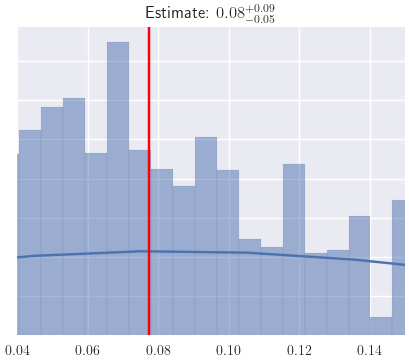

In [25]:
ax = density(dsurvival_all, figsize=(5, 4), xlim=(0.04, 0.15))
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylabel(None)
ax.spines['left'].set_visible(False)
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/dens_docs.pdf')

Ensuite, nous traçons la **courbe d'accumulation des espèces** pour l'ensemble. Cette courbe est pertinente pour les spécialistes de la littérature médiévale, car elle donne une indication du rythme auquel nous pourrions encore découvrir de nouvelles œuvres à l'avenir, en examinant davantage de documents (à condition que ces témoins ne soient pas définitivement perdus) :

In [26]:
# Définition du nombre maximum d'étapes pour l'accumulation des espèces
max_steps = 60000  # Ce nombre prend déjà en compte l'estimation minsample

# Calcul de la courbe d'accumulation des espèces en utilisant les données d'abondance
accumulation = species_accumulation(abundance, max_steps=max_steps)


100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


Sur ce graphique, nous ajouterons ensuite une estimation de densité par noyau qui montre les estimations bootstrap obtenues à partir de l'estimation `minsample` (sur l'axe secondaire horizontal). *Grosso modo*, la forme obtenue correspond à la zone où l'on s'attend à ce que la courbe asymptotique précédente commence à se stabiliser. Pendant la procédure de bootstrap de `minsample` initiée dans la cellule ci-dessous, des avertissements (`UserWarning`) peuvent apparaître de manière sporadique dans les cas où l'optimisation ne converge pas de manière satisfaisante. Cela fait partie du comportement attendu.



In [27]:
# Calcul de l'estimation 'minsample' de la diversité, en utilisant le solveur 'fsolve' et des intervalles de confiance (CI)
minsample_est = diversity(abundance, method='minsample', 
                          solver='fsolve', CI=True, n_iter=10000)


  0%|          | 10/10000 [00:00<02:11, 76.20it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9750744161778641 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9827817031676785 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9792084491480466 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9783086533745096 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python

Diff_intersect: 2177.766687692808


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:437: UserWarning: Tolerance criterion not met via fsolve: 2177.766687692808 > 0.1-> backing off to grid-solver.
  warnings.warn(msg)
  8%|▊         | 771/10000 [00:00<00:03, 2641.51it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9857974543109967 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9861228952103928 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Diff_intersect: 1982.8902205754093


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:437: UserWarning: Tolerance criterion not met via fsolve: 1982.8902205754093 > 0.1-> backing off to grid-solver.
  warnings.warn(msg)
 11%|█         | 1053/10000 [00:00<00:03, 2630.61it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9838709677419355 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")


Diff_intersect: 2177.766687692808


 13%|█▎        | 1349/10000 [00:00<00:03, 2742.90it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9782608695652174 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.98 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
 17%|█▋        | 1696/10000 [00:00<00:02, 2981.99it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9722222222222222 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9833540988364174 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
 24%|██▍  

Diff_intersect: 1982.8902205754093


 28%|██▊       | 2759/10000 [00:00<00:02, 3256.15it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9736842105263158 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.96875 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.975 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
 31%|███       | 3092/10000 [00:01<00:02, 3276.22it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9848639201744276 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/mi

Diff_intersect: 1982.8902205754093


 42%|████▏     | 4160/10000 [00:01<00:01, 3202.26it/s]

Diff_intersect: 2177.766687692808


 45%|████▍     | 4485/10000 [00:01<00:01, 3001.40it/s]

Diff_intersect: 1982.8902205754093


 48%|████▊     | 4790/10000 [00:01<00:01, 2937.96it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9865562008883164 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")


Diff_intersect: 1982.8902205754093


 51%|█████     | 5087/10000 [00:01<00:01, 2897.47it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9853853272569374 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")


Diff_intersect: 1982.8902205754093
Diff_intersect: 1982.8902205754093


 57%|█████▋    | 5741/10000 [00:01<00:01, 2982.47it/s]

Diff_intersect: 1982.8902205754093


 60%|██████    | 6044/10000 [00:02<00:01, 2902.14it/s]

Diff_intersect: 1982.8902205754093


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9843919846865655 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
 63%|██████▎   | 6338/10000 [00:02<00:01, 2858.79it/s]

Diff_intersect: 1982.8902205754093


 66%|██████▋   | 6627/10000 [00:02<00:01, 2866.95it/s]

Diff_intersect: 1982.8902205754093


 70%|██████▉   | 6964/10000 [00:02<00:01, 2918.74it/s]

Diff_intersect: 2177.766687692808
Diff_intersect: 2177.766687692808


 76%|███████▋  | 7633/10000 [00:02<00:00, 3055.15it/s]

Diff_intersect: 1982.8902205754093


 79%|███████▉  | 7942/10000 [00:02<00:00, 3045.28it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9723264087185662 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
 83%|████████▎ | 8300/10000 [00:02<00:00, 3196.14it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9838897163317923 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")


Diff_intersect: 1982.8902205754093


 86%|████████▋ | 8629/10000 [00:02<00:00, 3124.67it/s]

Diff_intersect: 2177.766687692808


 90%|████████▉ | 8971/10000 [00:03<00:00, 3069.60it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:454: UserWarning: Optimization failure likely: -0.9772727272727273 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
 93%|█████████▎| 9323/10000 [00:03<00:00, 3196.06it/s]

Diff_intersect: 1982.8902205754093


100%|██████████| 10000/10000 [00:03<00:00, 2963.76it/s]


Enfin, nous traçons le profil des nombres de Hill pour le jeux de données. Nous pouvons le faire à la fois pour les données empiriquement observées, ainsi que pour la reconstruction corrigée des biais :


In [30]:

###########
#Contexte :
###########
#Nombres de Hill : Ce sont des mesures de diversité qui généralise la richesse des espèces à différents ordres de diversité, 
# comme la diversité de Simpson ou la diversité de Shannon, permettant d'analyser à quel point les individus sont répartis équitablement entre les différentes catégories.

#Bootstrap et Parallélisation :
#Bootstrap est utilisé pour estimer la précision des statistiques en échantillonnant de manière répétée les données. 
# Cela permet d'obtenir une meilleure estimation de la variabilité.
#Parallélisation (n_jobs=4) permet de réduire le temps nécessaire pour effectuer un nombre important d'itérations 
# (comme ici avec 10 000) en exploitant plusieurs cœurs de processeur, ce qui est particulièrement utile pour des calculs intensifs.
#Le calcul des nombres de Hill est important pour comprendre la diversité de l'échantillon, en quantifiant à la fois la richesse (
# le nombre de types distincts) et l'équitabilité (la répartition de ces types).



# Calcul des nombres de Hill pour les données d'abondance, avec bootstrap et parallélisation
#  emp : Contient les nombres de Hill calculés à partir des données empiriquement observées (c'est-à-dire, les valeurs directes sans ajustement).
#  est : Contient les nombres de Hill après ajustement, généralement biais-corrigé, pour obtenir une estimation plus précise de la diversité.
emp, est = hill_numbers(abundance, n_iter=10000, n_jobs=4)


100%|██████████| 10000/10000 [00:17<00:00, 584.50it/s]


Nous combinons maintenant les statistiques calculées précédemment en un seul graphique, où la courbe d'accumulation des espèces est tracée à l'intérieur du graphique des nombres de Hill :


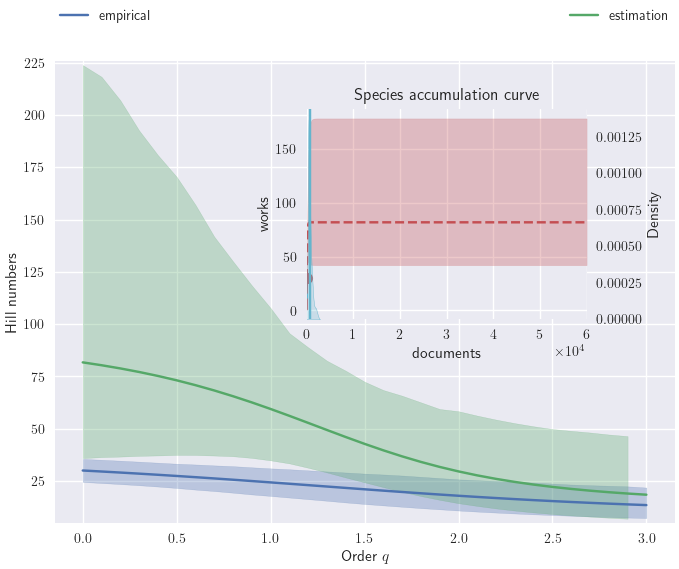

In [31]:
# Définition de la position et des dimensions de l'insertion du graphique
left, bottom, width, height = [0.44, 0.45, 0.35, 0.35]

# Création d'une figure et d'un axe principal
fig, ax = plt.subplots(figsize=(8, 6))

# Tracé du graphique des nombres de Hill pour les données empiriques et estimées
hill_plot(emp, est, add_densities=False, ax=ax)

# Création d'un deuxième axe pour la courbe d'accumulation des espèces, inséré dans l'axe principal
ax2 = fig.add_axes([left, bottom, width, height])

# Tracé de la courbe d'accumulation des espèces à l'intérieur du graphique des nombres de Hill
accumulation_curve(abundance, accumulation, c0='C2', c1='C5',
                   xlabel='documents', ylabel='works',
                   title='Courbe d\'accumulation des espèces', ax=ax2,
                   minsample=minsample_est, xlim=(0, max_steps))

# Suppression des graduations mineures sur l'axe Y
ax2.tick_params(axis='y', which='minor', left=False)

# Formatage de l'axe X en notation scientifique
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)


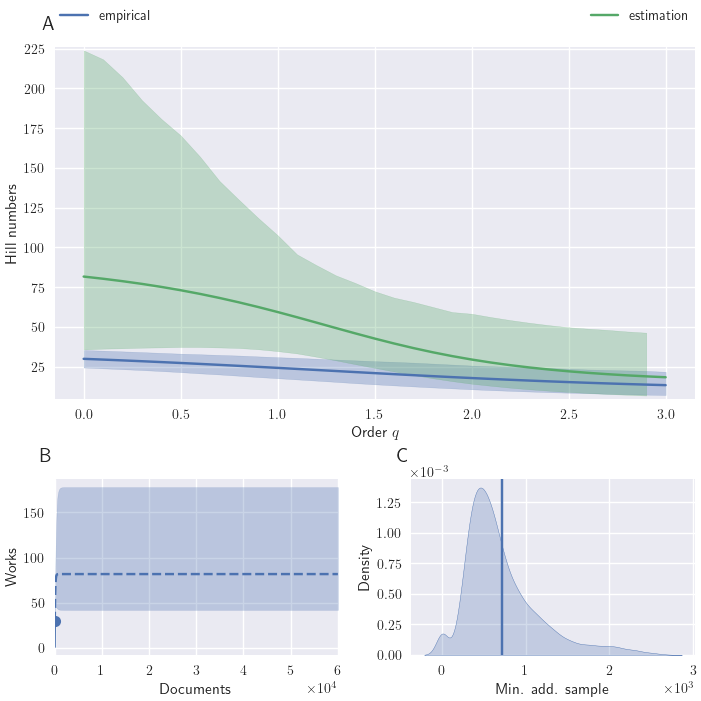

In [32]:
# Création d'une figure avec un agencement de sous-graphiques, de taille 7x7 pouces
fig = plt.figure(constrained_layout=True, figsize=(7, 7))
nrows, ncols = 3, 2  # Définition du nombre de lignes et de colonnes de la grille
gspec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)  # Spécification de la grille des sous-graphiques

# Création du premier sous-graphique, qui occupe les deux premières lignes et colonnes de la grille
ax = plt.subplot(gspec[:2, :2])
hill_plot(emp, est, add_densities=False, ax=ax)  # Tracé du profil des nombres de Hill pour les données observées et estimées
ax.text(-0.02, 1.05, "A", transform=ax.transAxes, fontweight='bold', fontsize=14)  # Annotation du sous-graphique avec "A"

# Création du deuxième sous-graphique, qui occupe la troisième ligne et la première colonne
ax2 = plt.subplot(gspec[2, 0])
accumulation_curve(abundance, accumulation, c0='C0', c1='C0',
                   xlabel='Documents', ylabel='Works',
                   title=None, ax=ax2,
                   xlim=(0, max_steps))  # Tracé de la courbe d'accumulation des espèces
ax2.tick_params(axis='y', which='minor', left=False)  # Suppression des graduations mineures sur l'axe Y
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)  # Formatage de l'axe X en notation scientifique
ax2.set_ylabel("Works")  # Définition de l'étiquette pour l'axe Y
ax2.text(-0.05, 1.1, "B", transform=ax2.transAxes, fontweight='bold', fontsize=14)  # Annotation du sous-graphique avec "B"

# Création du troisième sous-graphique, qui occupe la troisième ligne et la deuxième colonne
ax3 = plt.subplot(gspec[2, 1])
sb.kdeplot(minsample_est['bootstrap'], ax=ax3, color="C0", fill=True)  # Tracé de l'estimation de la densité par noyau pour 'minsample'
ax3.axvline(minsample_est['richness'], color="C0")  # Tracé d'une ligne verticale indiquant l'estimation de richesse

# Configuration du troisième sous-graphique
ax3.set(xlabel='Min. add. sample')  # Définition de l'étiquette pour l'axe X
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # Formatage de l'axe Y en notation scientifique
ax3.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)  # Formatage de l'axe X en notation scientifique
ax3.tick_params(axis='y', which='minor', left=True)  # Affichage des graduations mineures sur l'axe Y
ax3.text(-0.05, 1.1, "C", transform=ax3.transAxes, fontweight='bold', fontsize=14)  # Annotation du sous-graphique avec "C"

# Sauvegarde de la figure complète dans un fichier PDF
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/all_comb.pdf');


## Estimations pour chaque langue

Nous passons maintenant aux estimations pour les différentes langues vernaculaires considérées. Nous commençons par convertir les données de comptage disponibles en données d'abondance :


In [33]:
# Initialisation d'un dictionnaire pour stocker les assemblages par langue
assemblages = {}

# Boucle sur chaque ensemble de données de langue stocké dans le dictionnaire 'lits'
for lit, df in lits.items():
    # Conversion des données de titre en données d'abondance
    abundance = u.to_abundance(df['title'])
    
    # Stockage de l'abondance dans le dictionnaire 'assemblages' avec le nom de la langue en majuscule initiale
    assemblages[lit.title()] = abundance


In [34]:
assemblages

{'Portugais': array([2, 1, 1, 1]),
 'Castillan': array([2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 7, 1]),
 'Catalan': array([1, 1, 2, 1, 1])}

Les estimations ponctuelles pour la diversité originale de ces assemblages :


-  d'abord avec les intervalle de confiance :

In [196]:
# Boucle sur chaque catégorie d'assemblage dans le dictionnaire 'assemblages'
for category, assemblage in assemblages.items():
    
    # Affichage de la catégorie actuelle (langue)
    print('catégorie:', category)
    
    # Calcul et affichage de l'estimation de la diversité originale (méthode 'chao1') avec un intervalle de confiance
    print('  - nombre original d\'œuvres :', diversity(assemblage, method='chao1', CI=True))
    
    # Calcul et affichage de l'estimation originale du nombre de documents (méthode 'minsample') avec un intervalle de confiance
    print('  - nombre original de documents :', diversity(assemblage, method='minsample', CI=True))



category: Portugais


100%|██████████| 1000/1000 [00:00<00:00, 9195.74it/s]

  - original # works: {'richness': 7.6, 'lci': 3.4838000000000005, 'uci': 14.4838, 'std': 3.193251878571435, 'bootstrap': array([ 4.6838,  5.2838,  9.0838,  5.2838,  4.6838,  5.2838,  9.0838,
        9.0838,  5.2838,  9.0838, 14.4838,  3.4838, 14.4838,  5.2838,
        9.0838,  9.0838, 14.4838,  9.0838,  9.0838, 14.4838,  4.6838,
        5.2838,  9.0838,  4.6838,  5.2838,  4.6838,  5.2838,  9.0838,
        4.6838,  9.0838, 14.4838, 14.4838,  4.6838,  4.6838, 14.4838,
        9.0838,  3.4838,  9.0838, 14.4838,  3.4838, 14.4838,  9.0838,
        9.0838,  9.0838,  4.6838,  9.0838,  9.0838,  5.2838,  3.4838,
        9.0838, 14.4838,  3.4838,  9.0838,  9.0838,  4.6838,  5.2838,
       14.4838,  9.0838,  9.0838, 14.4838, 14.4838,  5.2838,  4.6838,
        9.0838,  5.2838, 14.4838,  5.2838,  9.0838,  4.6838,  9.0838,
        5.2838,  5.2838,  9.0838,  9.0838,  4.6838, 14.4838,  9.0838,
        9.0838,  9.0838,  9.0838,  4.6838,  4.6838,  4.6838,  9.0838,
        9.0838,  5.2838,  9.0838,  4.6


  0%|          | 1/1000 [00:00<02:52,  5.80it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 3.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 9.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 1.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 96%|█████████▌| 957/1000 [00:13<00:00, 68.80it/s]

  - original # documents: {'richness': 32.46952746952747, 'lci': 20.195280085562217, 'uci': 47.66480755508969, 'std': 13.444290319491696, 'bootstrap': array([20.19528009, 20.19528009, 47.66480756, 21.3142812 , 20.19528009,
       47.66480756, 21.3142812 , 20.19528009, 20.19528009, 47.66480756,
       47.66480756, 47.66480756, 47.66480756, 21.3142812 , 47.66480756,
       21.3142812 , 21.3142812 , 20.19528009, 47.66480756, 47.66480756,
       47.66480756, 21.3142812 , 47.66480756, 21.3142812 , 47.66480756,
       20.19528009, 47.66480756, 20.19528009, 47.66480756, 47.66480756,
       20.19528009, 20.19528009, 20.19528009, 20.19528009, 21.3142812 ,
       47.66480756, 47.66480756, 47.66480756, 20.19528009, 47.66480756,
       21.3142812 , 47.66480756, 20.19528009, 21.3142812 , 21.3142812 ,
       47.66480756, 20.19528009, 20.19528009, 47.66480756, 21.3142812 ,
       20.19528009, 20.19528009, 47.66480756, 47.66480756, 20.19528009,
       21.3142812 , 20.19528009, 47.66480756, 21.3142812 


100%|██████████| 1000/1000 [00:00<00:00, 9068.08it/s]

  - original # works: {'richness': 62.37373737373737, 'lci': 21.391631842231845, 'uci': 176.8461772967771, 'std': 43.430580542286975, 'bootstrap': array([ 56.50678336,  64.0522379 ,  65.24415709,  43.8502177 ,
        65.0522379 ,  23.61789447,  32.99163184,  17.96998682,
        37.02193487, 109.56738942,  42.87041972,  49.21385406,
       118.50678336, 141.65829851,  48.21385406, 118.50678336,
        88.59769245,  21.08254093,  79.59769245,  23.41587427,
        28.27041972,  21.08254093,  66.24415709, 129.4461773 ,
        32.99163184,  27.51111236,  88.59769245,  38.02193487,
        59.91082376,  49.4461773 ,  84.35526821,  33.09264194,
        50.56738942,  56.50678336,  38.80981366, 267.87041972,
        66.24415709,  32.19365204,  24.35526821,  33.92496518,
        42.8502177 ,  27.27041972,  22.88052073,  23.35526821,
        79.59769245,  25.62799548,  28.27041972, 175.62799548,
        97.47648033,  37.54314699,  37.02193487,  43.8502177 ,
        53.90072275,  29.69870255,


  2%|▏         | 21/1000 [00:00<00:15, 64.34it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 29.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
  3%|▎         | 28/1000 [00:00<00:14, 65.82it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 27.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  7%|▋         | 66/1000 [00:00<00:13, 71.02it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 43.0 > 0.1
  warnings.warn(f"Tolerance criterion no

  - original # documents: {'richness': 592.046959046959, 'lci': -74.98535458535457, 'uci': 2262.4710028709987, 'std': 611.0500704567256, 'bootstrap': array([ 6.75735696e+02,  5.31941352e+02,  4.84061604e+02,  2.57509778e+02,
        1.60740913e+03,  5.31941352e+02,  1.13203045e+03,  1.04891225e+02,
        4.49169653e+01,  8.98987519e+02,  4.36957357e+02,  9.75666396e+02,
        1.28925149e+02,  1.29702402e+03,  3.45299766e+02,  1.00809121e+02,
        6.75735696e+02,  7.48949569e+02,  2.31000851e+02,  4.84061604e+02,
        1.78867399e+02,  1.60740913e+03, -7.49853546e+01,  1.05336827e+03,
        4.84061604e+02,  1.92827175e+03,  1.91503112e+02,  3.23835528e+01,
        3.45299766e+02,  7.48949569e+02,  3.00881721e+02, -7.49853546e+01,
        3.93067313e+02,  1.91503112e+02,  3.45299766e+02,  5.80550401e+02,
        2.89440610e+02,  2.57509778e+02,  2.56100677e+02,  1.05336827e+03,
        1.78867399e+02,  2.56100677e+02,  2.23437244e+02,  1.29248550e+02,
        1.53602574e+02,  


100%|██████████| 1000/1000 [00:00<00:00, 9206.82it/s]

  - original # works: {'richness': 11.666666666666668, 'lci': 5.614916666666668, 'uci': 21.114916666666666, 'std': 4.791242995037926, 'bootstrap': array([ 7.44825   , 14.28158333, 14.28158333,  7.44825   , 21.11491667,
       14.28158333, 14.28158333,  4.61491667, 14.28158333,  9.11491667,
        9.11491667,  7.44825   , 14.28158333, 14.28158333, 14.28158333,
       21.11491667, 21.11491667,  7.44825   ,  9.11491667, 14.28158333,
        7.44825   , 14.28158333, 14.28158333,  7.44825   ,  4.61491667,
        7.44825   ,  7.44825   , 14.28158333, 21.11491667, 14.28158333,
       21.11491667,  7.44825   ,  6.03158333, 21.11491667, 21.11491667,
        9.11491667,  9.11491667,  7.44825   , 14.28158333, 21.11491667,
       14.28158333,  9.11491667,  7.44825   ,  7.44825   , 14.28158333,
        7.44825   ,  9.11491667, 14.28158333,  7.44825   , 14.28158333,
       14.28158333,  7.44825   , 14.28158333, 14.28158333, 14.28158333,
        9.11491667, 14.28158333,  6.44825   , 21.11491667, 14


  0%|          | 0/1000 [00:00<?, ?it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 5.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 3.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|▏         | 14/1000 [00:00<00:14, 66.95it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 11.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 15%|█▍        | 146

  - original # documents: {'richness': 58.22345222345223, 'lci': 36.06404516978535, 'uci': 88.28749739323757, 'std': 24.285743557082785, 'bootstrap': array([36.06404517, 88.28749739, 88.28749739, 88.28749739, 88.28749739,
       36.06404517, 39.50264861, 42.38025149, 88.28749739, 42.38025149,
       88.28749739, 36.06404517, 39.50264861, 42.38025149, 88.28749739,
       39.50264861, 42.38025149, 88.28749739, 36.06404517, 36.06404517,
       42.38025149, 88.28749739, 42.38025149, 88.28749739, 36.06404517,
       88.28749739, 42.38025149, 88.28749739, 36.06404517, 88.28749739,
       39.50264861, 36.06404517, 88.28749739, 36.06404517, 39.50264861,
       88.28749739, 88.28749739, 36.06404517, 36.06404517, 42.38025149,
       42.38025149, 88.28749739, 42.38025149, 88.28749739, 88.28749739,
       88.28749739, 88.28749739, 36.06404517, 88.28749739, 88.28749739,
       36.06404517, 42.38025149, 42.38025149, 36.06404517, 36.06404517,
       42.38025149, 88.28749739, 42.38025149, 88.28749739,

- et sans les intervalles de confiance :

In [197]:
for category, assemblage in assemblages.items():

    print('category:', category)
    print('  - original # works:', diversity(assemblage, method='chao1',CI=False))
    print('  - original # documents:', diversity(assemblage, method='minsample', CI=False))


category: Portugais
  - original # works: 7.6
  - original # documents: 32.46952746952747
category: Castillan
  - original # works: 62.37373737373737
  - original # documents: 592.046959046959
category: Catalan
  - original # works: 11.666666666666668
  - original # documents: 58.22345222345223


Nous sauvegardons ces resultats dans un dictionnaire

In [203]:
# Initialisation d'un dictionnaire pour stocker les diversités par catégorie
diversity_dic = {}

# Boucle sur chaque catégorie d'assemblage dans le dictionnaire 'assemblages'
for category, assemblage in assemblages.items():
    # Calculer la diversité des œuvres originales avec la méthode 'chao1' et un intervalle de confiance
    original_works_diversity = diversity(assemblage, method='chao1', CI=True)
    
    # Calculer la diversité des documents originaux avec la méthode 'minsample' et un intervalle de confiance
    original_documents_diversity = diversity(assemblage, method='minsample', CI=True)
    
    # Stocker les résultats dans le dictionnaire 'diversity_dic'
    diversity_dic[category] = {
        'original_works': original_works_diversity,
        'original_documents': original_documents_diversity
    }

    # Afficher les résultats (si nécessaire)
    print('catégorie:', category)
    print('  - nombre original d\'œuvres :', original_works_diversity['richness'], 'limite inférieure :', original_works_diversity['lci'], 'limite supérieure :', original_works_diversity['uci'])
    print('  - nombre original de documents :', original_documents_diversity['richness'], 'limite inférieure :', original_documents_diversity['lci'], 'limite supérieure :', original_documents_diversity['uci'])


  0%|          | 0/1000 [00:00<?, ?it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 9.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
  1%|          | 7/1000 [00:00<00:15, 64.64it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 3.0 > 0.1
  print(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  1%|▏         | 14/1000 [00:00<00:15, 62.20it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 1.0 > 0.1
  print(f"Tolerance criterion not met: {diff_intersect} > {tol

category: Portugais
  - original # works: 7.6 lowerbound: 3.495000000000001 uperbound: 14.495000000000001
  - original # documents: 32.46952746952747 lowerbound: 20.23261977327447 uperbound: 47.70214724280194


  5%|▌         | 50/1000 [00:00<00:13, 69.00it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 35.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
  6%|▋         | 65/1000 [00:00<00:13, 69.23it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 25.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
 16%|█▌        | 160/1000 [00:02<00:11, 71.36it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 31.0 > 0.1
  warnings.warn(f"Tolerance criterion no

category: Castillan
  - original # works: 62.37373737373737 lowerbound: 20.465783068783082 uperbound: 176.22411640211624
  - original # documents: 592.046959046959 lowerbound: -48.33826023826032 uperbound: 2284.915873015873



  0%|          | 0/1000 [00:00<?, ?it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 11.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
  1%|          | 7/1000 [00:00<00:15, 64.28it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 5.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 21/1000 [00:00<00:14, 67.96it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 3.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff

category: Catalan
  - original # works: 11.666666666666668 lowerbound: 5.2346666666666675 uperbound: 20.73466666666667
  - original # documents: 58.22345222345223 lowerbound: 35.759638720942185 uperbound: 87.9830909443944


Nous sauvegardons le resultats du dictionnaire dans un dataframe

In [207]:
# Création d'une liste pour stocker les données du DataFrame
div_data = []

# Boucle sur le dictionnaire 'diversity_dic' pour extraire les données pertinentes
for category, diversity_data in diversity_dic.items():
    # Ajouter un dictionnaire contenant les informations sur la richesse et les limites des œuvres et des documents
    div_data.append({
        'catégorie': category,
        'richesse_œuvres': diversity_data['original_works']['richness'],
        'borne_inférieure_œuvres': diversity_data['original_works']['lci'],
        'borne_supérieure_œuvres': diversity_data['original_works']['uci'],
        'richesse_documents': diversity_data['original_documents']['richness'],
        'borne_inférieure_documents': diversity_data['original_documents']['lci'],
        'borne_supérieure_documents': diversity_data['original_documents']['uci']
    })

# Création d'un DataFrame à partir de la liste de dictionnaires
df_results = pd.DataFrame(div_data)

# Affichage du DataFrame
print(df_results)



    category  works_richness  works_lowerbound  works_upperbound  \
0  Portugais        7.600000          3.495000         14.495000   
1  Castillan       62.373737         20.465783        176.224116   
2    Catalan       11.666667          5.234667         20.734667   

   documents_richness  documents_lowerbound  documents_upperbound  
0           32.469527             20.232620             47.702147  
1          592.046959            -48.338260           2284.915873  
2           58.223452             35.759639             87.983091  


... et le transformons dans un tableau Latex pour integrer dans notre memoire.

In [208]:
# Transformation du DataFrame en un format de tableau LaTeX
latex_tabular = df_results.to_latex(index=False)

# Affichage du code LaTeX
print(latex_tabular)


\begin{tabular}{lrrrrrr}
\toprule
  category &  works\_richness &  works\_lowerbound &  works\_upperbound &  documents\_richness &  documents\_lowerbound &  documents\_upperbound \\
\midrule
 Portugais &        7.600000 &          3.495000 &         14.495000 &           32.469527 &             20.232620 &             47.702147 \\
 Castillan &       62.373737 &         20.465783 &        176.224116 &          592.046959 &            -48.338260 &           2284.915873 \\
   Catalan &       11.666667 &          5.234667 &         20.734667 &           58.223452 &             35.759639 &             87.983091 \\
\bottomrule
\end{tabular}



## Survival rate

Les ratios de survie résultant de la procédure de bootstrap peuvent être calculés de la manière suivante :


- d'abord pour les oeuvres :

In [209]:
# Initialisation d'un dictionnaire pour stocker les ratios de survie par catégorie
wsurvival = {}

# Boucle sur chaque assemblage du dictionnaire 'assemblages'
for category, assemblage in assemblages.items():
    # Calculer le ratio de survie avec la méthode 'chao1' et l'ajouter au dictionnaire
    wsurvival[category] = survival_ratio(assemblage, method='chao1')


100%|██████████| 1000/1000 [00:00<00:00, 9379.31it/s]


`copia` propose deux fonctions auxiliaires pour visualiser et comparer les résultats (avec bootstrap) entre plusieurs assemblages. Tout d'abord, en utilisant des estimations de densité par noyau colorées :


In [113]:
#wsurvival['all'] = wsurvival_all

Premiere visualisation sur un graphique de densité par noyau :

/home/carolisteia/copia/copia/plot.py:252: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=ax, color=f"C{i}", shade=True)
/home/carolisteia/copia/copia/plot.py:252: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=ax, color=f"C{i}", shade=True)
/home/carolisteia/copia/copia/plot.py:252: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=ax, color=f"C{i}", shade=True)


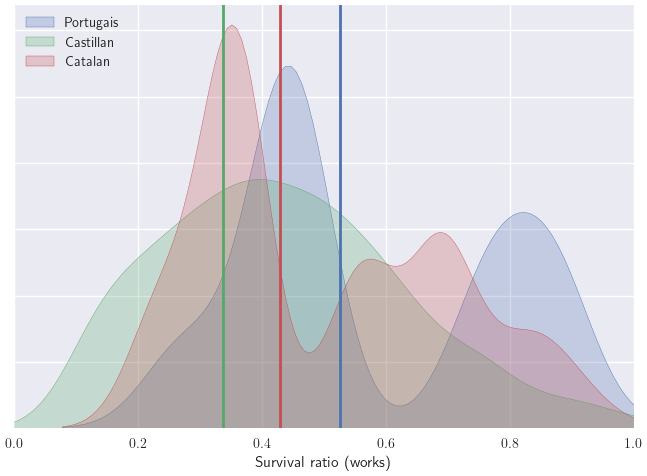

In [210]:
# Tracé de l'estimation de densité par noyau pour les ratios de survie avec 'multi_kde'
ax = multi_kde(wsurvival)

# Ajout d'une légende en haut à gauche du graphique
ax.legend(loc='upper left')

# Définition de l'étiquette pour l'axe X
ax.set_xlabel('Ratio de survie (œuvres)')

# Suppression des étiquettes des graduations de l'axe Y
ax.set_yticklabels([])

# Suppression des graduations sur l'axe Y
ax.tick_params(axis='y', which='both', left=False)

# Masquage de la bordure gauche du graphique
ax.spines['left'].set_visible(False)

# Sauvegarde du graphique en format PDF
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/survival_works_kde.pdf')


Deuxièmement, en utilisant des barres d'erreur correspondant aux intervalles de confiance :


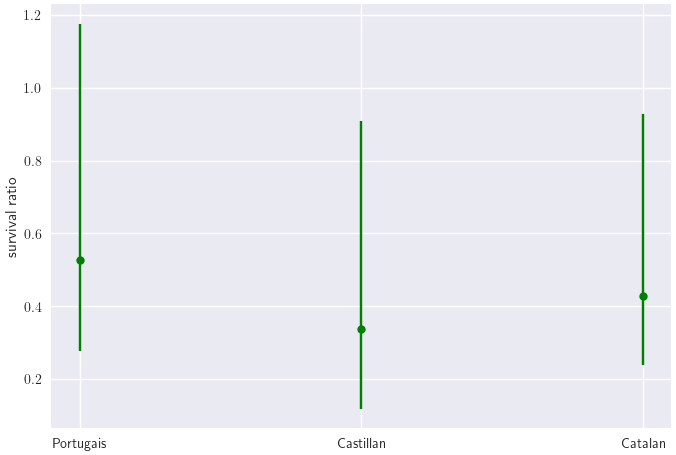

In [214]:
ax = survival_errorbar(wsurvival, ylabel="survival ratio")
ax.tick_params(axis='x', which='minor', bottom=False)
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/survival_works_error.pdf')

Maintenant, nous effectuons les mêmes procédures pour les documents, toujours avec le paramètre `method='minsample'` :


In [215]:
dsurvival = {}
for category, assemblage in assemblages.items():
    dsurvival[category] = survival_ratio(assemblage, method='minsample')

  0%|          | 0/1000 [00:00<?, ?it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 1.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:453: UserWarning: Optimization failure likely: 0.0 <= 0
  warnings.warn(f"Optimization failure likely: {x_ast} <= 0")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 3.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 9.0 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")
  2%|▏         | 23/1000 [00:00<00:13, 71.85it/s]/home/carolisteia/mini

/home/carolisteia/copia/copia/plot.py:252: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=ax, color=f"C{i}", shade=True)
/home/carolisteia/copia/copia/plot.py:252: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=ax, color=f"C{i}", shade=True)
/home/carolisteia/copia/copia/plot.py:252: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=ax, color=f"C{i}", shade=True)


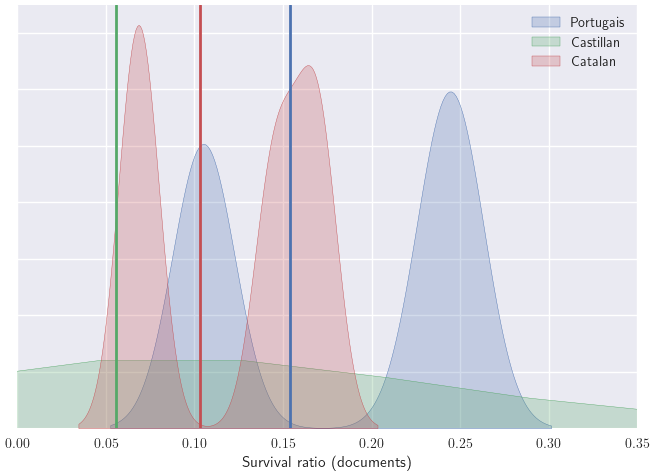

In [216]:
ax = multi_kde(dsurvival)
ax.legend(loc='upper right')
ax.set_xlim((0, 0.35))
ax.set_yticklabels([])
ax.tick_params(axis='y', which='both', left=False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Survival ratio (documents)')
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/survival_docs_kde.pdf')

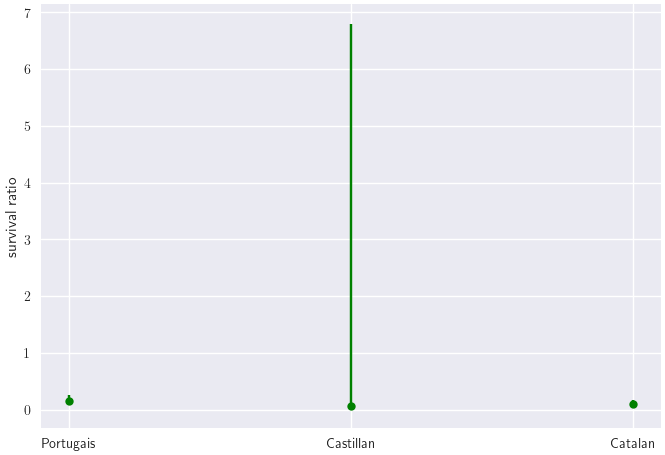

In [217]:
ax = survival_errorbar(dsurvival, ylabel="survival ratio")
ax.tick_params(axis='x', which='minor', bottom=False)
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/survival_docs_error.pdf')

Nous pouvons maintenant résumer les résultats des estimations pour chaque langue dans un tableau récapitulatif :


In [218]:
# Initialisation des colonnes supplémentaires du DataFrame avec des valeurs de 0.0
for c in 'CH1 CH1-lCI CH1-uCI MS MS-lCI MS-uCI'.split():
    stats_df[c] = 0.0

# Pour chaque langue individuelle :
for lang in wsurvival:
    stats_df.loc[lang.lower(), 'CH1'] = wsurvival[lang]['survival']  # Stocker le ratio de survie 'CH1'
    stats_df.loc[lang.lower(), 'CH1-lCI'] = wsurvival[lang]['lci']    # Stocker la borne inférieure de l'intervalle de confiance
    stats_df.loc[lang.lower(), 'CH1-uCI'] = wsurvival[lang]['uci']    # Stocker la borne supérieure de l'intervalle de confiance

for lang in dsurvival:
    stats_df.loc[lang.lower(), 'MS'] = dsurvival[lang]['survival']    # Stocker le ratio de survie 'MS'
    stats_df.loc[lang.lower(), 'MS-lCI'] = dsurvival[lang]['lci']     # Stocker la borne inférieure de l'intervalle de confiance
    stats_df.loc[lang.lower(), 'MS-uCI'] = dsurvival[lang]['uci']     # Stocker la borne supérieure de l'intervalle de confiance
    
# Pour l'union des assemblages :
stats_df.loc['all', 'CH1'] = wsurvival_all['survival']            # Stocker le ratio de survie 'CH1' pour l'ensemble des langues
stats_df.loc['all', 'CH1-lCI'] = wsurvival_all['lci']             # Stocker la borne inférieure de l'intervalle de confiance pour 'CH1'
stats_df.loc['all', 'CH1-uCI'] = wsurvival_all['uci']             # Stocker la borne supérieure de l'intervalle de confiance pour 'CH1'

stats_df.loc['all', 'MS'] = dsurvival_all['survival']             # Stocker le ratio de survie 'MS' pour l'ensemble des langues
stats_df.loc['all', 'MS-lCI'] = dsurvival_all['lci']              # Stocker la borne inférieure de l'intervalle de confiance pour 'MS'
stats_df.loc['all', 'MS-uCI'] = dsurvival_all['uci']              # Stocker la borne supérieure de l'intervalle de confiance pour 'MS'

# Arrondir les valeurs du DataFrame à 3 décimales
stats_df.round(3)


,f1,f2,S,n,repo,CH1,CH1-lCI,CH1-uCI,MS,MS-lCI,MS-uCI
language,,,,,,,,,,,
portugais,3,1,4,5,5,0.526,0.278,1.176,0.154,0.105,0.249
castillan,16,3,21,33,15,0.337,0.118,0.910,0.056,0.015,6.800
catalan,4,1,5,6,6,0.429,0.239,0.927,0.103,0.068,0.169
all,23,5,30,44,None,0.367,0.126,0.841,0.062,0.020,0.284


Ensuite nous exportons le résultat dans un tableau LaTeX pour l'inclure dans le mémoire :


In [219]:
with open('/home/carolisteia/Desktop/filologia_iberica/outputs/results.txt', 'w') as f:
    f.write(stats_df.round(3).to_latex())

### Evenness

Pour visualiser les profils d'équitabilité, nous devons d'abord calculer le profil des nombres de Hill (estimés, reconstruits) pour chacune des langues :


In [220]:
# Initialisation d'un dictionnaire pour stocker les estimations des nombres de Hill par langue
hill_est = {}

# Boucle sur chaque assemblage du dictionnaire 'assemblages'
for lang, assemblage in assemblages.items():
    # Calculer les nombres de Hill pour les données observées (emp) et estimées (est)
    emp, est = hill_numbers(assemblage, n_iter=10000)
    
    # Stocker les estimations des nombres de Hill dans le dictionnaire 'hill_est'
    hill_est[lang] = est


  0%|          | 1/10000 [00:00<18:01,  9.24it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/hill.py:49: RuntimeWarning: invalid value encountered in double_scalars
  return (A + B)**(1 / (1 - q))
  0%|          | 0/10000 [00:00<?, ?it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/hill.py:49: RuntimeWarning: invalid value encountered in double_scalars
  return (A + B)**(1 / (1 - q))
100%|██████████| 10000/10000 [00:30<00:00, 330.46it/s]


Nous pouvons calculer les profils d'équitabilité (normalisés) à partir des profils des nombres de Hill :


In [221]:
evennesses = {l:evenness(hill_est[l]) for l in hill_est}

Le tracé de ces profils dans un seul graphique peut être effectué en appelant la fonction auxiliaire associée :


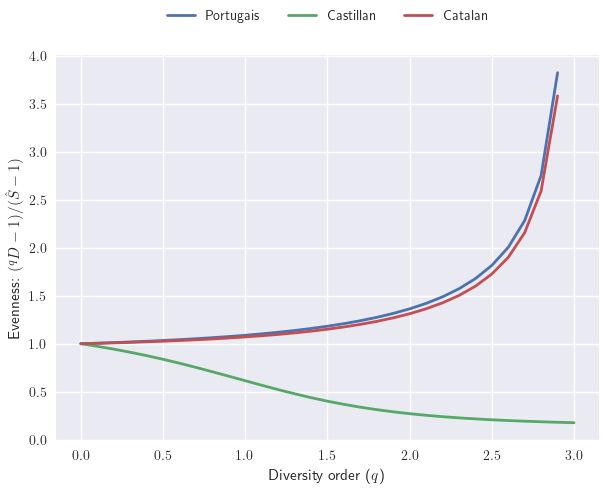

In [222]:
# Tracé des profils d'équitabilité à l'aide de la fonction 'evenness_plot'
ax = evenness_plot(evennesses, figsize=(7, 5))

# Activation des graduations mineures sur l'axe Y
ax.tick_params(axis='y', which='minor', left=True)

# Récupération des lignes et des étiquettes de la légende
lines, labels = ax.get_legend_handles_labels()

# Suppression du titre du graphique
ax.set_title(None)

# Ajout de la légende au-dessus du graphique, centrée, avec 3 colonnes
ax.legend(lines, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), frameon=False)

# Sauvegarde du graphique en format PDF
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/evenness.pdf')


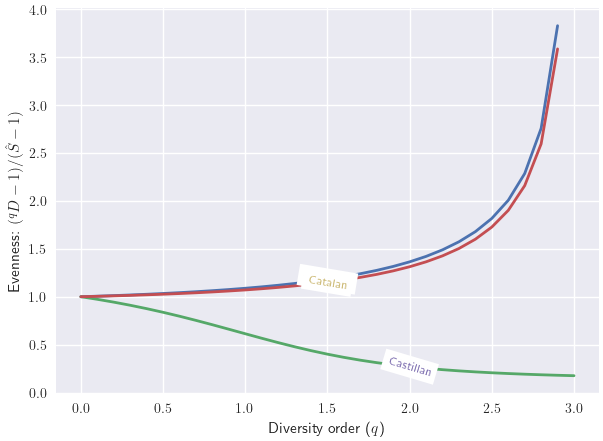

In [223]:
ax = evenness_plot(evennesses, figsize=(7, 5))
ax.tick_params(axis='y', which='minor', left=True)
lines, labels = ax.get_legend_handles_labels()
ax.set_title(None)
# ax.legend(lines, labels, loc = 'upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), frameon=False)
ax.get_legend().remove()

qs = np.arange(0, 3.1, 0.1)



ax.text(qs[20], evennesses['Castillan'][20], " " + "Castillan",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C3", ha="center", va="center", rotation=-16.5)

ax.text(qs[15], evennesses['Portugais'][15], " " + "Portugais",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C5", ha="center", va="center", rotation=-9.5)

ax.text(qs[15], evennesses['Catalan'][15], " " + "Catalan",
        size="small", bbox=dict(facecolor='white', edgecolor="None", alpha=1),
        color="C4", ha="center", va="center", rotation=-9.5)

plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/evenness-inset-text.pdf')

Nous pouvons répéter cela pour les autres classes de mesures d'équitabilité ($E_1$ à $E_5$) :


/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/utils.py:230: RuntimeWarning: invalid value encountered in true_divide
  (1 - (d['richness'][0] ** qs)))


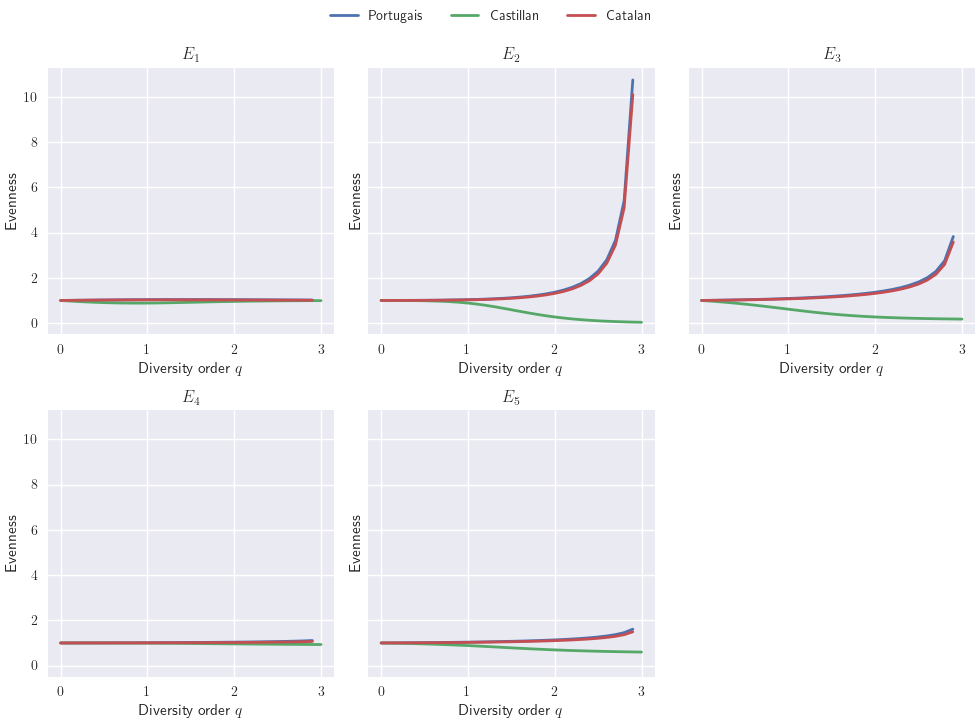

In [224]:
# Création d'une figure avec une grille de sous-graphiques de 2 lignes et 3 colonnes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), sharey=True)
axes = axes.flatten()  # Aplatir la grille des axes pour faciliter l'itération

# Boucle sur les valeurs de 1 à 5 pour tracer les profils d'équitabilité correspondants
for i in range(1, 6):
    # Calcul des profils d'équitabilité pour chaque assemblage, avec l'ordre de diversité 'E=i'
    evennesses = {l:evenness(hill_est[l], E=i) for l in hill_est}
    
    # Tracé du profil d'équitabilité dans l'axe correspondant
    ax = evenness_plot(evennesses, xlabel="Ordre de diversité $q$", ylabel="Équitabilité", ax=axes[i-1])
    
    # Définir le titre du graphique avec la notation mathématique pour l'ordre 'E_i'
    ax.set_title(f"$E_{i}$")
    
    # Activation des graduations mineures sur l'axe Y
    ax.tick_params(axis='y', which='minor', left=True)
    
    # Suppression de la légende pour éviter les doublons
    ax.get_legend().remove()

# Suppression du dernier sous-graphe vide
axes[-1].remove()  # Ne pas afficher l'axe vide

# Récupération des lignes et étiquettes de la légende pour l'ensemble de la figure
lines, labels = fig.axes[-1].get_legend_handles_labels()
# Ajout de la légende globale au-dessus de la figure, avec 6 colonnes
fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.05), frameon=False)

# Ajustement de la disposition des sous-graphes pour éviter le chevauchement
plt.tight_layout()

# Sauvegarde de la figure en format PDF
plt.savefig(f"/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/evenness-plots.pdf", bbox_inches='tight')


## Estimateurs supplémentaires


Meme si nous nous concentrons sur **Chao1**, il est utile de comparer les résultats avec un certain nombre d'autres estimateurs pour la survie des œuvres. Avec `copia`, les alternatives suivantes sont disponibles :
- **Jackknife** d'ordre supérieur : une méthode plus générale pour la correction des biais en statistiques
- **iChao1** : une variante de Chao1, qui prend également en compte $f_3$ et $f_4$
- L'estimateur **Egghe & Proot**, utilisant le paramètre par défaut `alpha=150`.


In [225]:
# Initialisation d'une liste vide pour stocker les comparaisons
comp = []

# Boucle sur chaque estimateur à utiliser pour calculer le ratio de survie
for estimator in ['chao1', 'jackknife', 'ichao1', 'egghe_proot']:
    # Boucle sur chaque assemblage (tradition/langue) du dictionnaire 'assemblages'
    for category, assemblage in assemblages.items():
        # Calculer le ratio de survie pour l'assemblage avec l'estimateur spécifié
        surv = survival_ratio(assemblage, method=estimator, n_iter=10000)
        
        # Ajouter les résultats sous forme de liste : [tradition, estimateur, ratio de survie, borne inférieure, borne supérieure]
        comp.append([category, estimator, surv['survival'], surv['lci'], surv['uci']])

# Création d'un DataFrame à partir de la liste des comparaisons, avec des noms de colonnes appropriés
comp = pd.DataFrame(comp, columns=['tradition', 'estimateur', 'ratio_survie', 'borne_inférieure', 'borne_supérieure'])


100%|██████████| 10000/10000 [00:00<00:00, 17453.34it/s]
/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|          | 0/10000 [00:00<?, ?it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:185: UserWarning: Add-one smoothing for P2 = 0
  warnings.warn("Add-one smoothing for P2 = 0", UserWarning)
  2%|▏         | 163/10000 [00:00<00:08, 1153.41it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:185: UserWarning: Add-one smoothing for P2 = 0
  warnings.warn("Add-one smoothing for P2 = 0", UserWarning)
  0%|          | 0/10000 [00:00<?, ?it/s]/home/carolisteia/miniconda3/envs/forgotten/lib/python3.7/site-packages/copia/richness.py:185: UserWarning: Add-one smoothing for P2 = 0
  warnings.warn("Add-one smoothing for P2 = 0", UserWarning)
 98%|█████████▊|

Tri des Données du DataFrame *comp*

In [226]:
# Trier le DataFrame 'comp' par les colonnes 'tradition' et 'estimateur', et stocker le résultat dans 'estimates'
estimates = comp.sort_values(['tradition', 'estimateur'])

# Affichage du DataFrame trié
estimates


,tradition,estimator,survival,lci,uci
1,Castillan,chao1,0.336680,0.119542,1.043458
10,Castillan,egghe_proot,0.314113,0.098910,1.199394
7,Castillan,ichao1,0.336680,0.110095,1.162944
4,Castillan,jackknife,0.350000,0.237550,0.664611
2,Catalan,chao1,0.428571,0.238844,0.856097
11,Catalan,egghe_proot,0.394992,0.213821,0.864102
8,Catalan,ichao1,0.428571,0.240571,0.858292
5,Catalan,jackknife,0.555556,0.343793,1.446598
0,Portugais,chao1,0.526316,0.277219,1.166521
9,Portugais,egghe_proot,0.488109,0.246373,1.160048


In [227]:
# Remplacer les caractères de soulignement '_' par des espaces dans la colonne 'estimateur'
estimates["estimateur"] = estimates["estimateur"].str.replace("_", " ")


Exportation des Résultats sous Forme de Tableau LaTeX

In [228]:
# Ouvrir un fichier pour écrire les résultats au format LaTeX
with open('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/other.txt', 'w') as f:
    # Écrire dans le fichier les estimations, arrondies à 3 décimales, converties au format LaTeX
    f.write(estimates.round(3).to_latex())


Visualisation des resultats :

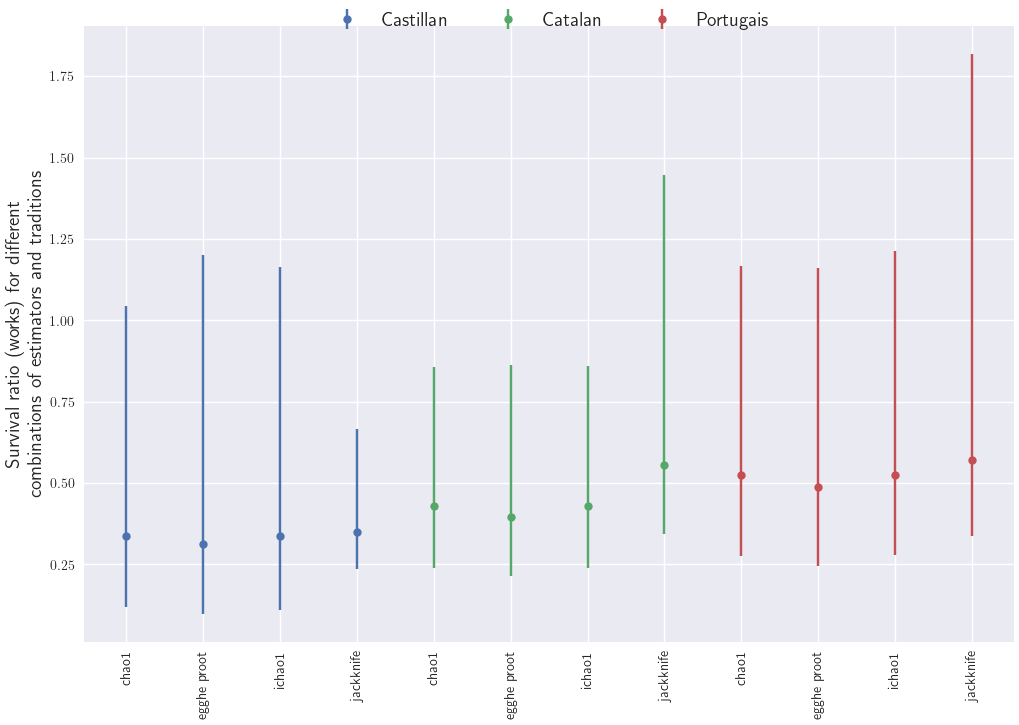

In [229]:
# Création des barres d'erreur basées sur les intervalles de confiance inférieurs et supérieurs
errors = np.array(list(zip(estimates['lci'], estimates['uci']))).T
errors[0] = estimates['survival'] - errors[0]  # Calcul des erreurs négatives
errors[1] -= estimates['survival']  # Calcul des erreurs positives

# Création de la figure et de l'axe pour le tracé
fig, ax = plt.subplots(figsize=(12, 8))

# Définition des traditions et des couleurs associées
traditions = sorted(set(estimates['tradition']))
color_dict = {t: f"C{i}" for i, t in enumerate(traditions)}  # Assigner une couleur différente à chaque tradition
labeled = {t: False for t in color_dict}  # Dictionnaire pour vérifier si une tradition a déjà été étiquetée

# Boucle sur les estimations pour tracer les barres d'erreur pour chaque combinaison d'estimateur et de tradition
for idx in range(len(estimates)):
    trad = estimates['tradition'].iloc[idx]  # Obtenir la tradition correspondante à l'index
    meth = estimates['estimator'].iloc[idx]  # Obtenir l'estimateur correspondant à l'index
    label = trad if not labeled[trad] else None  # Ajouter une étiquette seulement si la tradition n'a pas encore été étiquetée
    c = color_dict[trad]  # Couleur associée à la tradition
    labeled[trad] = True  # Marquer la tradition comme étiquetée
    ax.errorbar(idx, estimates['survival'].iloc[idx],
                yerr=np.array([errors[:, idx]]).T,
                fmt='.', c=color_dict[trad], label=label,
                ms=12)  # Tracer le point avec une barre d'erreur

# Configuration de l'axe Y
ax.set_ylabel('Ratio de survie (œuvres) pour différentes\ncombinaisons d\'estimateurs et de traditions', fontsize=14)

# Configuration de l'axe X
ax.set_xticks(np.arange(len(estimates)))
ax.set_xticklabels(estimates['estimator'], rotation=90)  # Tourner les étiquettes de l'axe X pour plus de lisibilité
ax.tick_params(axis='x', which='minor', bottom=False)  # Supprimer les graduations mineures en bas
ax.tick_params(axis='y', which='minor', left=True)  # Activer les graduations mineures sur l'axe Y

# Ajout de la légende
ax.legend(loc='upper center', ncol=len(assemblages), bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=14)

# Sauvegarde du graphique en format PDF
plt.savefig('/home/carolisteia/Desktop/filologia_iberica/memoire_M2/usm/outputs/other.pdf');
